# Del 2: Procesiranje velikih datasetov v pandas-u

Viri:
- [Tutorial: Using Pandas with Large Data Sets in Python](https://www.dataquest.io/blog/pandas-big-data/)
- [How to handle large datasets in Python with Pandas and Dask](https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55)
- [Why is Python so slow?](https://hackernoon.com/why-is-python-so-slow-e5074b6fe55b)
- [Why Python is Slow: Looking Under the Hood](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/)
- [Make working with large DataFrames easier, at least for your memory](https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4)
- [“Large data” work flows using pandas](https://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas)
- [Why and How to Use Pandas with Large Data](https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c)
- [4 Strategies to Deal With Large Datasets Using Pandas](https://www.codementor.io/guidotournois/4-strategies-to-deal-with-large-datasets-using-pandas-qdw3an95k)

## Introduction & Data

We'll be working with data on the Museum of Modern Art's exhibitions. More specifically, we'll use the file `MoMAExhibitions1929to1989.csv`, which you can download from [data.world](https://data.world/moma/exhibitions).

In [1]:
import pandas as pd
import numpy as np

In [2]:
moma = pd.read_csv('data/MoMAExhibitions1929to1989.csv')

In [3]:
moma.head(2)

ExhibitionID ExhibitionNumber                     ExhibitionTitle  \
0        2557.0                1  Cézanne, Gauguin, Seurat, Van Gogh   
1        2557.0                1  Cézanne, Gauguin, Seurat, Van Gogh   

                        ExhibitionCitationDate ExhibitionBeginDate  \
0  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
1  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   

  ExhibitionEndDate  ExhibitionSortOrder  \
0         12/7/1929                  1.0   
1         12/7/1929                  1.0   

                                   ExhibitionURL ExhibitionRole  \
0  http://www.moma.org/calendar/exhibitions/1767       Director   
1  http://www.moma.org/calendar/exhibitions/1767         Artist   

   ConstituentID  ... Institution Nationality ConstituentBeginDate  \
0         9168.0  ...         NaN    American               1902.0   
1         1053.0  ...         NaN      French               1839.0   

  ConstituentEndDate            ArtistBio Gender       VIAFID WikidataID  \
0             1981.0  American, 1902–1981   Male  109252853.0    Q711362   
1             1906.0    French, 1839–1906   Male   39374836.0     Q35548   

        ULANID         ConstituentURL  
0  500241556.0  moma.org/artists/9168  
1  500004793.0  moma.org/artists/1053  

[2 rows x 27 columns]

In [4]:
moma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ExhibitionID            34129 non-null  float64
 1   ExhibitionNumber        34558 non-null  object 
 2   ExhibitionTitle         34558 non-null  object 
 3   ExhibitionCitationDate  34557 non-null  object 
 4   ExhibitionBeginDate     34558 non-null  object 
 5   ExhibitionEndDate       33354 non-null  object 
 6   ExhibitionSortOrder     34558 non-null  float64
 7   ExhibitionURL           34125 non-null  object 
 8   ExhibitionRole          34424 non-null  object 
 9   ConstituentID           34044 non-null  float64
 10  ConstituentType         34424 non-null  object 
 11  DisplayName             34424 non-null  object 
 12  AlphaSort               34424 non-null  object 
 13  FirstName               31499 non-null  object 
 14  MiddleName              3804 non-null 

## Optimizing Dataframe Memory Footprint

### The Internal Representation of a Dataframe

<img src="./images/pandas_dataframe_blocks.png">

In [5]:
moma._data

BlockManager
Items: Index(['ExhibitionID', 'ExhibitionNumber', 'ExhibitionTitle',
       'ExhibitionCitationDate', 'ExhibitionBeginDate', 'ExhibitionEndDate',
       'ExhibitionSortOrder', 'ExhibitionURL', 'ExhibitionRole',
       'ConstituentID', 'ConstituentType', 'DisplayName', 'AlphaSort',
       'FirstName', 'MiddleName', 'LastName', 'Suffix', 'Institution',
       'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate',
       'ArtistBio', 'Gender', 'VIAFID', 'WikidataID', 'ULANID',
       'ConstituentURL'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=34558, step=1)
FloatBlock: [ 0  6  9 19 20 23 25], 7 x 34558, dtype: float64
ObjectBlock: [ 1  2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 21 22 24 26], 20 x 34558, dtype: object

### Dataframe Memory Footprint

#### Float Columns

In [6]:
34558*8

276464

In [7]:
moma['ExhibitionID'].nbytes #velikost datoteke v byte-ih

276464

In [ ]:
#pri stringih shranjuje samo pointerje, ki kažejo, kje tekst je. Pointerji so 8 bitni. Dejanska poraba pomnilnika je večja.

#### Object Columns

<img src="./images/numpy_vs_python.png">

#### True Memory Footprint

In [8]:
moma.size

933066

In [9]:
total_bytes = moma.size*8

In [12]:
total_megabytes = total_bytes/(1024*1024)

In [13]:
print('Total bytes:', total_bytes)
print('Total megabytes:', total_megabytes)

Total bytes: 7464528
Total megabytes: 7.1187286376953125


In [14]:
moma.info(memory_usage = 'deep') #pove dejansko velikost data frame-a v pomnilniku

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ExhibitionID            34129 non-null  float64
 1   ExhibitionNumber        34558 non-null  object 
 2   ExhibitionTitle         34558 non-null  object 
 3   ExhibitionCitationDate  34557 non-null  object 
 4   ExhibitionBeginDate     34558 non-null  object 
 5   ExhibitionEndDate       33354 non-null  object 
 6   ExhibitionSortOrder     34558 non-null  float64
 7   ExhibitionURL           34125 non-null  object 
 8   ExhibitionRole          34424 non-null  object 
 9   ConstituentID           34044 non-null  float64
 10  ConstituentType         34424 non-null  object 
 11  DisplayName             34424 non-null  object 
 12  AlphaSort               34424 non-null  object 
 13  FirstName               31499 non-null  object 
 14  MiddleName              3804 non-null 

In [15]:
moma.memory_usage(deep=True) #prava velikost vsakega stolpca

Index                         128
ExhibitionID               276464
ExhibitionNumber          2085850
ExhibitionTitle           3333695
ExhibitionCitationDate    3577728
ExhibitionBeginDate       2281851
ExhibitionEndDate         2234872
ExhibitionSortOrder        276464
ExhibitionURL             3494606
ExhibitionRole            2179383
ConstituentID              276464
ConstituentType           2313112
DisplayName               2548428
AlphaSort                 2534329
FirstName                 2104929
MiddleName                1218953
LastName                  2162941
Suffix                    1110349
Institution               1221368
Nationality               1949664
ConstituentBeginDate       276464
ConstituentEndDate         276464
ArtistBio                 3183300
Gender                    1858994
VIAFID                     276464
WikidataID                1821293
ULANID                     276464
ConstituentURL            2677922
dtype: int64

In [16]:
moma.memory_usage(deep=True)/(1024*1024) #prava velikost vsakega stolpca v MB

Index                     0.000122
ExhibitionID              0.263657
ExhibitionNumber          1.989222
ExhibitionTitle           3.179259
ExhibitionCitationDate    3.411987
ExhibitionBeginDate       2.176143
ExhibitionEndDate         2.131340
ExhibitionSortOrder       0.263657
ExhibitionURL             3.332716
ExhibitionRole            2.078422
ConstituentID             0.263657
ConstituentType           2.205956
DisplayName               2.430370
AlphaSort                 2.416924
FirstName                 2.007417
MiddleName                1.162484
LastName                  2.062741
Suffix                    1.058911
Institution               1.164787
Nationality               1.859344
ConstituentBeginDate      0.263657
ConstituentEndDate        0.263657
ArtistBio                 3.035831
Gender                    1.772875
VIAFID                    0.263657
WikidataID                1.736920
ULANID                    0.263657
ConstituentURL            2.553865
dtype: float64

> **index** : *bool, default True* --> 
Specifies whether to include the memory usage of the DataFrame’s index in returned Series. If index=True, the memory usage of the index is the first item in the output.

In [17]:
moma.memory_usage(deep=True, index=False) #indexa ne vključi v velikost DF

ExhibitionID               276464
ExhibitionNumber          2085850
ExhibitionTitle           3333695
ExhibitionCitationDate    3577728
ExhibitionBeginDate       2281851
ExhibitionEndDate         2234872
ExhibitionSortOrder        276464
ExhibitionURL             3494606
ExhibitionRole            2179383
ConstituentID              276464
ConstituentType           2313112
DisplayName               2548428
AlphaSort                 2534329
FirstName                 2104929
MiddleName                1218953
LastName                  2162941
Suffix                    1110349
Institution               1221368
Nationality               1949664
ConstituentBeginDate       276464
ConstituentEndDate         276464
ArtistBio                 3183300
Gender                    1858994
VIAFID                     276464
WikidataID                1821293
ULANID                     276464
ConstituentURL            2677922
dtype: int64

In [18]:
def get_memory_usage_by_type(df, types=[]):
    if not types:
        types = []
        for column in df.columns:
            if hasattr(df[column], 'cat'):
                types.append('category')
            else:
                types.append(df[column].dtype)
        types = list(set(types))
    total = 0
    for dtype in types:
        selected_dtype = df.select_dtypes(include=[dtype])
        num_of_columns = len(selected_dtype.columns)
        mean_usage_b = selected_dtype.memory_usage(deep=True, index=False).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        sum_usage_b = selected_dtype.memory_usage(deep=True, index=False).sum()
        sum_usage_mb = sum_usage_b / 1024 ** 2
        print(f"Average memory usage: {round(mean_usage_mb, 3)} MB and total: {round(sum_usage_mb, 3)} MB for {num_of_columns}x {dtype} columns.")
        total += sum_usage_mb
        
    print('----------------------')
    print(f'Total memory usage: {round(total, 3)} MB')

In [19]:
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


### Optimizing Numeric Columns with Subtypes

<table>
<thead>
<tr>
<th>memory usage</th>
<th>float</th>
<th>int</th>
<th>uint</th>
<th>datetime</th>
<th>bool</th>
<th>object</th>
</tr>
</thead>
<tbody>
<tr>
<td>1 bytes</td>
<td></td>
<td>int8</td>
<td>uint8</td>
<td></td>
<td>bool</td>
<td></td>
</tr>
<tr>
<td>2 bytes</td>
<td>float16</td>
<td>int16</td>
<td>uint16</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>4 bytes</td>
<td>float32</td>
<td>int32</td>
<td>uint32</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>8 bytes</td>
<td>float64</td>
<td>int64</td>
<td>uint64</td>
<td>datetime64</td>
<td></td>
<td></td>
</tr>
<tr>
<td>variable</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>object</td>
</tr>
</tbody>
</table>

In [20]:
int_types = ["int8", "int16", "int32", "int64"]

for it in int_types:
    print (np.iinfo(it))




Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



#### Integer Columns

In [26]:
moma.select_dtypes(include=['float']).isnull().sum()

ExhibitionID              429
ExhibitionSortOrder         0
ConstituentID             514
ConstituentBeginDate     9268
ConstituentEndDate      14739
VIAFID                   7562
ULANID                  12870
dtype: int64

In [21]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
moma.select_dtypes(include=['float']).head()

ExhibitionID  ExhibitionSortOrder  ConstituentID  ConstituentBeginDate  \
0        2557.0                  1.0         9168.0                1902.0   
1        2557.0                  1.0         1053.0                1839.0   
2        2557.0                  1.0         2098.0                1848.0   
3        2557.0                  1.0         2206.0                1853.0   
4        2557.0                  1.0         5358.0                1859.0   

   ConstituentEndDate       VIAFID       ULANID  
0              1981.0  109252853.0  500241556.0  
1              1906.0   39374836.0  500004793.0  
2              1903.0   27064953.0  500011421.0  
3              1890.0    9854560.0  500115588.0  
4              1891.0   24608076.0  500008873.0

In [22]:
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


In [27]:
# Function to convert to best integer subtype
def convert_col_to_best_int_subtype(df, columns=[]):
    for column in columns:
        col_max = df[column].max()
        col_min = df[column].min()
        
        if col_max < np.iinfo('int8').max and col_min > np.iinfo('int8').min:
            df[column] = df[column].astype('int8')
        elif col_max <  np.iinfo("int16").max and col_min > np.iinfo("int16").min:
            df[column] = df[column].astype("int16")
        elif col_max <  np.iinfo("int32").max and col_min > np.iinfo("int32").min:
            df[column] = df[column].astype("int32")
        elif col_max <  np.iinfo("int64").max and col_min > np.iinfo("int64").min:
            df[column] = df[column].astype("int64")

In [25]:
moma.select_dtypes(include=['float']).isnull().sum()

ExhibitionID              429
ExhibitionSortOrder         0
ConstituentID             514
ConstituentBeginDate     9268
ConstituentEndDate      14739
VIAFID                   7562
ULANID                  12870
dtype: int64

In [28]:
convert_col_to_best_int_subtype(moma, ['ExhibitionSortOrder'])

In [29]:
moma.dtypes.value_counts()

object     20
float64     6
int16       1
dtype: int64

In [24]:
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


#### Float Columns

In [30]:
# Reset the dataframe to the original CSV
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")

moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype('int')
moma['ExhibitionSortOrder'].dtype

dtype('int64')

In [31]:
# Reset the dataframe to the original CSV
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")

moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype('int') #najprej moramo pretvoriti v integer
moma['ExhibitionSortOrder'] = pd.to_numeric(moma['ExhibitionSortOrder'], downcast = 'integer') #sprememba v najbolj ugoden integer

moma['ExhibitionSortOrder'].dtype

dtype('int16')

In [32]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
get_memory_usage_by_type(moma)

# convert int columns
convert_col_to_best_int_subtype(moma, ['ExhibitionSortOrder'])

# convert folat columns
float_cols = moma.select_dtypes(include=['float'])
for col in float_cols.columns:
    moma[col] = pd.to_numeric(moma[col], downcast = 'float')
    

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


In [33]:
moma.dtypes.value_counts()

object     20
float32     6
int16       1
dtype: int64

In [34]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 44.624 MB


### Converting To DateTime

In [35]:
moma.head(2)

ExhibitionID ExhibitionNumber                     ExhibitionTitle  \
0        2557.0                1  Cézanne, Gauguin, Seurat, Van Gogh   
1        2557.0                1  Cézanne, Gauguin, Seurat, Van Gogh   

                        ExhibitionCitationDate ExhibitionBeginDate  \
0  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
1  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   

  ExhibitionEndDate  ExhibitionSortOrder  \
0         12/7/1929                    1   
1         12/7/1929                    1   

                                   ExhibitionURL ExhibitionRole  \
0  http://www.moma.org/calendar/exhibitions/1767       Director   
1  http://www.moma.org/calendar/exhibitions/1767         Artist   

   ConstituentID  ... Institution Nationality ConstituentBeginDate  \
0         9168.0  ...         NaN    American               1902.0   
1         1053.0  ...         NaN      French               1839.0   

  ConstituentEndDate            ArtistBio Gender       VIAFID WikidataID  \
0             1981.0  American, 1902–1981   Male  109252856.0    Q711362   
1             1906.0    French, 1839–1906   Male   39374836.0     Q35548   

        ULANID         ConstituentURL  
0  500241568.0  moma.org/artists/9168  
1  500004800.0  moma.org/artists/1053  

[2 rows x 27 columns]

In [36]:
moma['ExhibitionEndDate'].isnull().sum()

1204

In [37]:
moma['ExhibitionEndDate']= pd.to_datetime(moma['ExhibitionEndDate'])

In [38]:
#hitrejši način
moma['ExhibitionEndDate']= pd.to_datetime(moma['ExhibitionEndDate'], format='%m%d%Y')

In [39]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.264 MB and total: 0.264 MB for 1x datetime64[ns] columns.
Average memory usage: 2.191 MB and total: 41.636 MB for 19x object columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
----------------------
Total memory usage: 42.757 MB


In [40]:
moma.dtypes.value_counts()

object            19
float32            6
datetime64[ns]     1
int16              1
dtype: int64

In [41]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.264 MB and total: 0.264 MB for 1x datetime64[ns] columns.
Average memory usage: 2.191 MB and total: 41.636 MB for 19x object columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
----------------------
Total memory usage: 42.757 MB


### Converting to Categorical

In [ ]:
#če je uniquenes stolpca večji kot 50%, se stolpca ne splača konvertirati. Kar je manjše od 30% se splača

In [44]:
moma['ConstituentType'].unique()

array(['Individual', nan, 'Institution'], dtype=object)

In [45]:
moma['ConstituentType'].value_counts()

Individual     32008
Institution     2416
Name: ConstituentType, dtype: int64

In [48]:
moma['ConstituentType'].memory_usage(deep = True)

2313240

In [49]:
moma['ConstituentType'] = moma['ConstituentType'].astype('category')

In [50]:
get_memory_usage_by_type(moma)

Average memory usage: 2.191 MB and total: 39.43 MB for 18x object columns.
Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.033 MB and total: 0.033 MB for 1x category columns.
Average memory usage: 0.264 MB and total: 0.264 MB for 1x datetime64[ns] columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
----------------------
Total memory usage: 40.584 MB


In [51]:
moma['ConstituentType'].head()

0    Individual
1    Individual
2    Individual
3    Individual
4    Individual
Name: ConstituentType, dtype: category
Categories (2, object): ['Individual', 'Institution']

In [52]:
obj_col = moma.select_dtypes(include=['object'])

In [55]:
for col in obj_col.columns:
    num_unique_values = len(moma[col].unique())
    num_total_values = len(moma[col])
    
    if ((num_unique_values/num_total_values)*100) < 50:
        moma[col] = moma [col].astype('category') 
    

In [56]:
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 0.264 MB for 1x datetime64[ns] columns.
Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.407 MB and total: 7.741 MB for 19x category columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
----------------------
Total memory usage: 8.861 MB


## Selecting Types While Reading the Data In

### Example: MoMA dataset

In [57]:
moma_sample = pd.read_csv("data/MoMAExhibitions1929to1989.csv", nrows=3) #preberemo nekaj vrstic za ogled podatkov

In [58]:
moma_sample

ExhibitionID  ExhibitionNumber                     ExhibitionTitle  \
0          2557                 1  Cézanne, Gauguin, Seurat, Van Gogh   
1          2557                 1  Cézanne, Gauguin, Seurat, Van Gogh   
2          2557                 1  Cézanne, Gauguin, Seurat, Van Gogh   

                        ExhibitionCitationDate ExhibitionBeginDate  \
0  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
1  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
2  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   

  ExhibitionEndDate  ExhibitionSortOrder  \
0         12/7/1929                    1   
1         12/7/1929                    1   
2         12/7/1929                    1   

                                   ExhibitionURL ExhibitionRole  \
0  http://www.moma.org/calendar/exhibitions/1767       Director   
1  http://www.moma.org/calendar/exhibitions/1767         Artist   
2  http://www.moma.org/calendar/exhibitions/1767         Artist   

   ConstituentID  ... Institution Nationality ConstituentBeginDate  \
0           9168  ...         NaN    American                 1902   
1           1053  ...         NaN      French                 1839   
2           2098  ...         NaN      French                 1848   

  ConstituentEndDate            ArtistBio Gender     VIAFID  WikidataID  \
0               1981  American, 1902–1981   Male  109252853     Q711362   
1               1906    French, 1839–1906   Male   39374836      Q35548   
2               1903    French, 1848–1903   Male   27064953      Q37693   

      ULANID         ConstituentURL  
0  500241556  moma.org/artists/9168  
1  500004793  moma.org/artists/1053  
2  500011421  moma.org/artists/2098  

[3 rows x 27 columns]

In [60]:
moma_sample.columns.to_list()

['ExhibitionID',
 'ExhibitionNumber',
 'ExhibitionTitle',
 'ExhibitionCitationDate',
 'ExhibitionBeginDate',
 'ExhibitionEndDate',
 'ExhibitionSortOrder',
 'ExhibitionURL',
 'ExhibitionRole',
 'ConstituentID',
 'ConstituentType',
 'DisplayName',
 'AlphaSort',
 'FirstName',
 'MiddleName',
 'LastName',
 'Suffix',
 'Institution',
 'Nationality',
 'ConstituentBeginDate',
 'ConstituentEndDate',
 'ArtistBio',
 'Gender',
 'VIAFID',
 'WikidataID',
 'ULANID',
 'ConstituentURL']

In [61]:
keep_cols = ['ExhibitionID', 'ExhibitionNumber', 'ExhibitionBeginDate', 
             'ExhibitionEndDate', 'ExhibitionSortOrder', 'ExhibitionRole', 
             'ConstituentType', 'DisplayName', 'Institution', 'Nationality', 
             'Gender']

In [62]:
col_types = {'ExhibitionID': np.float32, 
             'ExhibitionNumber': 'category',
             'ExhibitionSortOrder': np.float16, 
             'ExhibitionRole': 'category', 
             'ConstituentType' : 'category', 
             'DisplayName' : 'category', 
             'Institution': 'category',  
             'Nationality' : 'category', 
             'Gender': 'category'}

In [63]:
date_cols = ["ExhibitionBeginDate", "ExhibitionEndDate"]

In [64]:
moma = pd.read_csv('data/MoMAExhibitions1929to1989.csv',
                  usecols=keep_cols, #usecols - katere vrstice naj uporabi
                  parse_dates = date_cols,
                  dtype = col_types)

In [65]:
get_memory_usage_by_type(moma)

Average memory usage: 0.066 MB and total: 0.066 MB for 1x float16 columns.
Average memory usage: 0.264 MB and total: 0.527 MB for 2x datetime64[ns] columns.
Average memory usage: 0.132 MB and total: 0.132 MB for 1x float32 columns.
Average memory usage: 0.266 MB and total: 1.861 MB for 7x category columns.
----------------------
Total memory usage: 2.587 MB


## Processing Dataframes in Chunks

### Processing Chunks

<img src="./images/processing_chunks_overview.png">

In [66]:
import pandas as pd
import numpy as np

In [67]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=10000) #chunksize je podan v vrsticah

In [68]:
chunk_iter

In [69]:
for chunk in chunk_iter:
    print(len(chunk))   #ko pride iterator enkrat skozi, se ga več ne da uporabiti. Treba ga je pognati ponovno od začetka.

10000
10000
10000
4558


In [70]:
# Create an iterator object that reads in 250-row chunks from "moma.csv".
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250)

In [72]:
# For each chunk, retrieve the memory footprint in megabytes and append it to the list memory_footprints.
memory_footprints = []

for chunk in chunk_iter:
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/(1024*1024))

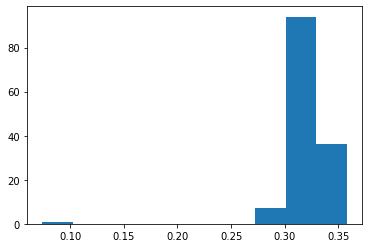

In [73]:
# Generate and display a histogram of the values in memory_footprints using pyplot.hist()
import matplotlib.pyplot as plt

plt.hist(memory_footprints)
plt.show()

### Counting Across Chunks

In [74]:
# Create an iterator object that reads in 250-row chunks from "moma.csv".
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250)

In [75]:
# For each chunk, retrieve the number of rows and add it to num_rows.
num_rows = 0

for chunk in chunk_iter:
    num_rows += len(chunk)


In [76]:
num_rows

34558

### Batch Processing

<img src="./images/process_chunks_count.png">

In [77]:
series_list = [pd.Series([1,2]), pd.Series([2,3])]

pd.concat(series_list)

0    1
1    2
0    2
1    3
dtype: int64

In [78]:
lifespans = []

In [79]:
dtypes = { 'ConstituentBeginDate': 'float',
          'ConstituentEndDate': 'float'}

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", 
                         chunksize=250,
                        dtype=dtypes)

In [80]:
for chunk in chunk_iter:
    diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
    lifespans.append(diff)


In [82]:
lifespans_dist = pd.concat(lifespans)

In [83]:
lifespans_dist.head()

0    79.0
1    67.0
2    55.0
3    37.0
4    32.0
dtype: float64

In [84]:
len(lifespans_dist)

34558

In [85]:
max(lifespans_dist)

105.0

### Optimizing Performance

In [86]:
%%timeit
lifespans = []

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250, 
                         dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"})

for chunk in chunk_iter:
        diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
        lifespans.append(diff)

lifespans_dist = pd.concat(lifespans)


743 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%%timeit
lifespans = []

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250, 
                         dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"},  
                         usecols=['ConstituentBeginDate', 'ConstituentEndDate'])

for chunk in chunk_iter:
    lifespans.append(chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate'])
    
lifespans_dist = pd.concat(lifespans)

295 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Counting Unique Values

<img src="./images/processing_chunks_value_counts.png">

We can use the pandas.concat() function to combine all of the chunks at the end.

In [88]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['Gender'])

In [89]:
overall_vc = []

for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)
combined_vc = pd.concat(overall_vc)


In [90]:
combined_vc.head(10)

Male      208
Female      9
Male      193
Female      6
Male      195
Female      8
Male      104
Female      6
Male      103
Female     10
Name: Gender, dtype: int64

### Combining Chunks Using GroupBy

In [91]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['Gender'])

overall_vc = []

In [92]:
overall_vc = []

for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)
combined_vc = pd.concat(overall_vc)


In [93]:
final_vc = combined_vc.groupby(combined_vc.index).sum()

In [94]:
final_vc

Female     2527
Male      23268
male          1
Name: Gender, dtype: int64

## Analizing big files with Pandas and SQLite

In [95]:
import sqlite3 #sql je omejen s količino diska in ne s količino rama

In [96]:
conn = sqlite3.connect('data/moma.db')

In [97]:
moma_iter = pd.read_csv('data/moma.csv', chunksize=1000)

In [98]:
for chunk in moma_iter:
    chunk.to_sql('exhibitions', conn, if_exists='append', index=False)

### Computing Primarily in SQL

In [99]:
conn = sqlite3.connect('data/moma.db')

In [100]:
q = '''SELECT exhibitionid, count(*) AS counts 
    from exhibitions 
    GROUP BY exhibitionid 
    ORDER BY counts desc;'''

In [101]:
eid_counts = pd.read_sql(q, conn)

In [102]:
conn.close()

In [103]:
eid_counts.head(10)

ExhibitionID  counts
0           NaN    1287
1           7.0     963
2        3838.0     906
3        3030.0     852
4        3988.0     825
5        2600.0     786
6          79.0     777
7       10601.0     768
8        3939.0     762
9        3036.0     732

### Computing Primarily in Pandas

In [106]:
conn = sqlite3.connect('data/moma.db')

q = 'SELECT exhibitionid from exhibitions'
eid_counts = pd.read_sql(q, conn)
conn.close()
eid_counts_pandas = eid_counts['ExhibitionID'].value_counts()
eid_counts_pandas.head()

7.0       963
3838.0    906
3030.0    852
3988.0    825
2600.0    786
Name: ExhibitionID, dtype: int64

### Reading in SQL Results Using Chunks

In [107]:
conn = sqlite3.connect('data/moma.db')

In [108]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=100)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

4.13 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=1000)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

1.65 s ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=10000)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

1.2 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Vaja: Primer analize velikega dataseta

In [113]:
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', nrows = 5)
chunk_iter

company_permalink company_name company_category_code  \
0    /company/advercar     AdverCar           advertising   
1  /company/launchgram   LaunchGram                  news   
2        /company/utap         uTaP             messaging   
3    /company/zoopshop     ZoopShop              software   
4    /company/efuneral     eFuneral                   web   

  company_country_code company_state_code         company_region  \
0                  USA                 CA                 SF Bay   
1                  USA                 CA                 SF Bay   
2                  USA                NaN  United States - Other   
3                  USA                 OH               Columbus   
4                  USA                 OH              Cleveland   

    company_city          investor_permalink      investor_name  \
0  San Francisco  /company/1-800-flowers-com  1-800-FLOWERS.COM   
1  Mountain View        /company/10xelerator        10Xelerator   
2            NaN        /company/10xelerator        10Xelerator   
3       columbus        /company/10xelerator        10Xelerator   
4      Cleveland        /company/10xelerator        10Xelerator   

  investor_category_code investor_country_code investor_state_code  \
0                    NaN                   USA                  NY   
1                finance                   USA                  OH   
2                finance                   USA                  OH   
3                finance                   USA                  OH   
4                finance                   USA                  OH   

  investor_region investor_city funding_round_type   funded_at funded_month  \
0        New York      New York           series-a  2012-10-30      2012-10   
1        Columbus      Columbus              other  2012-01-23      2012-01   
2        Columbus      Columbus              other  2012-01-01      2012-01   
3        Columbus      Columbus              angel  2012-02-15      2012-02   
4        Columbus      Columbus              other  2011-09-08      2011-09   

  funded_quarter  funded_year  raised_amount_usd  
0        2012-Q4         2012            2000000  
1        2012-Q1         2012              20000  
2        2012-Q1         2012              20000  
3        2012-Q1         2012              20000  
4        2011-Q3         2011              20000

In [132]:
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

In [133]:
mv_list = []

for chunk in chunk_iter:
    print(chunk.memory_usage(deep = True).sum()/(1024*1024))
    mv_list.append(chunk.isnull().sum())


5.579240798950195
5.528232574462891
5.535050392150879
5.5282087326049805
5.52435302734375
5.553458213806152
5.531436920166016
5.5096588134765625
5.396136283874512
4.639497756958008
2.6637144088745117


In [134]:
combined_mv_mc = pd.concat(mv_list)
unique_combined_mv_mc = combined_mv_mc.groupby(combined_mv_mc.index).sum()
unique_combined_mv_mc.sort_values()

company_country_code          1
company_name                  1
company_permalink             1
company_region                1
investor_region               2
investor_permalink            2
investor_name                 2
funded_quarter                3
funded_at                     3
funded_month                  3
funded_year                   3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64

In [135]:
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

total_rows = 0

for chunk in chunk_iter:
    total_rows += len(chunk)
    
print(total_rows) #preštete vrstice

52870


In [146]:
unique_combined_mv_mc_per =unique_combined_mv_mc.sort_values()/total_rows*100

In [ ]:
drop_cols = unique_combined_mv_mc

In [144]:
def get_columns_to_drop (series, per=60):
    drop_cols = series[series > per].index.to_list()
    return drop_cols

In [147]:
get_columns_to_drop(unique_combined_mv_mc_per, 20)

['investor_country_code',
 'investor_city',
 'investor_state_code',
 'investor_category_code']

In [148]:
# Drop columns representing URL's or containing way too many missing values (>90% missing)
drop_cols = ['investor_permalink', 'company_permalink', 
             'investor_category_code']

In [151]:
keep_cols = chunk.columns.drop(drop_cols)
keep_cols.tolist()

['company_name',
 'company_category_code',
 'company_country_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_type',
 'funded_at',
 'funded_month',
 'funded_quarter',
 'funded_year',
 'raised_amount_usd']

In [152]:
# Key: Column name, Value: List of types
col_types = {}
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='ISO-8859-1', 
                         usecols=keep_cols)

for chunk in chunk_iter:
    chunk.to_sql('investments', conn, if_exists ='append', index = False)

    

In [153]:
import sqlite3
conn = sqlite3.connect('data/crunchbase.db')
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='ISO-8859-1',
                         usecols=keep_cols)

for chunk in chunk_iter:
    chunk.to_sql('investments', conn, if_exists ='append', index = False)



Which category of company attracted the most investments?

In [154]:
q = '''SELECT company_category_code, count(*) AS counts 
    from investments 
    GROUP BY company_category_code 
    ORDER BY counts desc;'''

In [155]:
data = pd.read_sql(q, conn)

In [162]:
data.head()

company_category_code  counts
0              software    7243
1                   web    5015
2               biotech    4951
3            enterprise    4489
4                mobile    4067

<AxesSubplot:xlabel='company_category_code'>

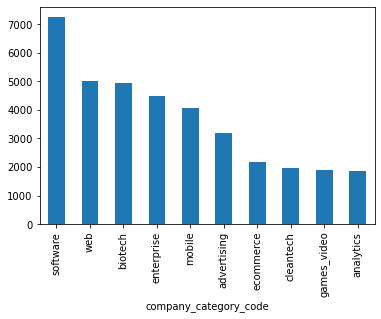

In [160]:
data.head(10).plot(kind = 'bar', x='company_category_code', y = 'counts', legend = False)

## More file formats

- [Big Data file formats](https://luminousmen.com/post/big-data-file-formats)

### [Parquet](https://parquet.apache.org/)

Launched in 2013, Parquet was developed by Cloudera and Twitter to serve as a column-based storage format, optimized for work with multi-column datasets. Because data is stored by columns, it can be highly compressed (compression algorithms perform better on data with low information entropy which is usually contained in columns) and splittable. The developers of the format claim that this storage format is ideal for Big Data problems.

### [Avro](https://avro.apache.org/)

Apache Avro was released by the Hadoop working group in 2009. It is a row-based format that is highly splittable. It also described as a data serialization system similar to Java Serialization. The schema is stored in JSON format while the data is stored in binary format, minimizing file size and maximizing efficiency. Avro has robust support for schema evolution by managing added fields, missing fields, and fields that have changed. This allows old software to read the new data and new software to read the old data — a critical feature if your data has the potential to change.

### [Feather](https://github.com/wesm/feather)

Feather provides binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy. Feather uses the Apache Arrow columnar memory specification to represent binary data on disk. This makes read and write operations very fast. This is particularly important for encoding null/NA values and variable-length types like UTF8 strings.

Feather is a part of the broader Apache Arrow project. Feather defines its own simplified schemas and metadata for on-disk representation.

### [HDF5](https://portal.hdfgroup.org/display/knowledge/What+is+HDF5)

HDF5 is a unique technology suite that makes possible the management of extremely large and complex data collections.

The HDF5 technology suite is designed to organize, store, discover, access, analyze, share, and preserve diverse, complex data in continuously evolving heterogeneous computing and storage environments.

HDF5 supports all types of data stored digitally, regardless of origin or size. Petabytes of remote sensing data collected by satellites, terabytes of computational results from nuclear testing models, and megabytes of high-resolution MRI brain scans are stored in HDF5 files, together with metadata necessary for efficient data sharing, processing, visualization, and archiving.